In [1]:
%matplotlib inline 

import six
import Quandl
import calendar
import math
import numpy as np
import pandas as pd
import seaborn as sb
import pylab as pylab
from datetime import datetime

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal
import statsmodels.api as sm 
import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, ensemble
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import preprocessing

import sys
from os import listdir
from os.path import isfile, join
from helpers import features_analysis, procces_stocks, data_manipulation, download_quandl_data, ml_dataset
from classes import Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')

In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
OIL_BRENT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'OIL_BRENT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, OIL_BRENT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD_AM', 'USD', 'USD_AM', 'USD', 'Open', 'Open', 'Open', 'Open', 'Open']
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)
dataset = dataset.fillna(method='ffill')

In [3]:
training_dates = Iteration.Iteration('1993-08-19', '2012-07-06')
testing_dates  = Iteration.Iteration('2012-07-09', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)

dataset =  ml_dataset.remove_columns_from_dataset(dataset, 'close', False)
trainX, trainY, testX, testY, cols = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False)

trainX = preprocessing.Imputer().fit_transform(trainX)
testX = preprocessing.Imputer().fit_transform(testX)

['IBEX_RD_B1_Close']


In [4]:
N_TREES = 500
SEED = 42


selected_models = [
    "LRC:dataset",    
    "RFC:dataset",
    "GBC:dataset"
    #"RFC:effects_f",  # experimental; added after the competition
]


# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC': linear_model.LogisticRegression,
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier}[model_id]()
    model.set_params(random_state=SEED)
    models.append(model)


################
##  Boosting  ##
################
    
boosting = Boosting.Boosting(models)

###  Metrics
mean_auc = 0.0
iter_ = 1
for i in range(iter_):        
    boosting.fit_predict(trainX, trainY, testX, testY)

> AUC: 0.5146 [LR]
> AUC: 0.7391 [RFC]
> AUC: 0.8012 [GBC]
modelEN1.coef [[-0.1185102   0.0347031   0.89506153]]
> AUC: 0.5450 [LR]
> AUC: 0.7455 [RFC]
> AUC: 0.7968 [GBC]
modelEN2.coef [[ 0.46881044  0.01708068  0.909877  ]]
> AUC: 0.7455 


compute_scores...
n_components pca...
n_components fa...
best n_components by PCA CV = 125
best n_components by FactorAnalysis CV = 115


NameError: name 'rank' is not defined

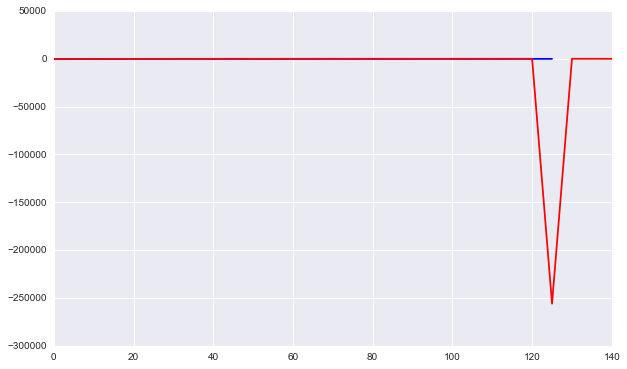

In [4]:
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

# Fit the models
n_features = trainX.shape[1]
n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = decomposition.PCA()
    fa = decomposition.FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

for X, title in [(trainX, 'Data')]:
    print "compute_scores..."
    pca_scores, fa_scores = compute_scores(X)
    print "n_components pca..."
    n_components_pca = n_components[np.argmax(pca_scores)]
    print "n_components fa..."    
    n_components_fa = n_components[np.argmax(fa_scores)]

#    pca = decomposition.PCA(n_components='mle')
#    pca.fit(X)
#    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
#    print("best n_components by PCA MLE = %d" % n_components_pca_mle)
#
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
#    plt.axvline(n_components_pca_mle, color='k',
#                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')
#
    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
#    plt.axhline(lw_score(X), color='orange',
#                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')
#
    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

In [37]:
#data_manipulation.write_csv_data(GOLD, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(OIL_BRENT, '/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')